# Peringkas Berita Bahasa Indonesia dengan RNN

## Pendahuluan

Proyek ini bertujuan untuk membangun model sequence-to-sequence untuk tugas peringkasan teks otomatis (Text Summarization). Kami akan mengimplementasikan arsitektur Encoder-Decoder menggunakan lapisan `SimpleRNN` murni untuk melatih model yang mampu membaca sebuah artikel berita berbahasa Indonesia dan menghasilkan ringkasan yang lebih pendek.

## Setup & Impor Library

Pada bagian ini, kami mengimpor semua library yang akan dibutuhkan untuk keseluruhan proyek, mulai dari pemrosesan data hingga pembangunan dan evaluasi model.

In [30]:
# Library dasar untuk manipulasi data dan komputasi
import os
import pandas as pd
import numpy as np
import re
import json

# Library untuk visualisasi
import matplotlib.pyplot as plt
from IPython.display import display

# Library TensorFlow dan Keras untuk pra-pemrosesan dan model
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Embedding, SimpleRNN, Dense
from tensorflow.keras.models import Model

# Library dari Scikit-learn untuk membagi data
from sklearn.model_selection import train_test_split

print("Semua library berhasil diimpor.")
print("Versi TensorFlow:", tf.__version__)

Semua library berhasil diimpor.
Versi TensorFlow: 2.19.0


## Persiapan Dataset (IndoSum)

### Mengunduh dan Mengekstrak Dataset

Pertama, kami mengunduh dataset IndoSum (yang berformat .tar.gz) dan mengekstraknya langsung di lingkungan Colab.

In [31]:
# Langkah 1: Unduh dataset indosum.tar.gz dari link Google Drive
# Menggunakan ID file dari URL yang Anda berikan
!gdown --id 1OgYbPfXFAv3TbwP1Qcwt_CC9cVWSJaco

# Langkah 2: Ekstrak file .tar.gz yang sudah diunduh
# Perintah 'tar -xzvf' digunakan untuk file .tar.gz
!tar -xzvf indosum.tar.gz

print("\nDataset IndoSum berhasil diunduh dan diekstrak.")

# Langkah 3: Verifikasi isi folder hasil ekstraksi
# Biasanya hasil ekstraksi dari file .tar.gz akan membuat folder 'indosum'
print("\nIsi dari folder 'indosum':")
!ls indosum

/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1OgYbPfXFAv3TbwP1Qcwt_CC9cVWSJaco
From (redirected): https://drive.google.com/uc?id=1OgYbPfXFAv3TbwP1Qcwt_CC9cVWSJaco&confirm=t&uuid=d178290b-0b47-4100-8547-f7f94380c648
To: /content/indosum.tar.gz
100% 96.0M/96.0M [00:00<00:00, 107MB/s]
indosum/
indosum/test.02.jsonl
indosum/README.txt
indosum/train.05.jsonl
indosum/train.04.jsonl
indosum/test.04.jsonl
indosum/train.01.jsonl
indosum/test.05.jsonl
indosum/test.03.jsonl
indosum/test.01.jsonl
indosum/dev.04.jsonl
indosum/dev.01.jsonl
indosum/dev.02.jsonl
indosum/train.02.jsonl
indosum/dev.03.jsonl
indosum/dev.05.jsonl
indosum/CHANGELOG.txt
indosum/train.03.jsonl

Dataset IndoSum berhasil diunduh dan diekstrak.

Isi dari folder 'indosum':
CHANGELOG.txt  dev.04

### Pemuatan Data

Pada bagian ini, dataset IndoSum yang telah diekstrak dimuat dari file JSON Lines (`indosum/train.01.jsonl`) ke dalam Pandas DataFrame untuk memudahkan manipulasi data.

In [32]:
# Path ke salah satu file training di dalam folder yang sudah diekstrak
file_path = 'indosum/train.01.jsonl'

# Membaca data dari file JSON Lines
try:
    # Menggunakan pd.read_json dengan lines=True yang cocok untuk format .jsonl
    df = pd.read_json(file_path, lines=True)

    print(f"Dataset prototipe ('{file_path}') berhasil dimuat.")
    print(f"Jumlah data: {len(df)} sampel.")

    print("\nContoh 5 Baris Pertama Data:")
    # Kami akan fokus pada kolom 'paragraphs' dan 'summary'
    display(df[['paragraphs', 'summary']].head())

    print("\nMemeriksa apakah ada data yang hilang:")
    print(df.isnull().sum())

except FileNotFoundError:
    print(f"ERROR: File '{file_path}' tidak ditemukan. Pastikan proses ekstraksi sebelumnya berhasil.")
except Exception as e:
    print(f"Terjadi error saat membaca file: {e}")

Dataset prototipe ('indosum/train.01.jsonl') berhasil dimuat.
Jumlah data: 14262 sampel.

Contoh 5 Baris Pertama Data:


,paragraphs,summary
0,"[[[Jakarta, ,, CNN, Indonesia, -, -, Dokter, R...","[[Dokter, Lula, Kamal, yang, merupakan, selebr..."
1,"[[[Selfie, ialah, salah, satu, tema, terpanas,...","[[Asus, memperkenalkan, , ZenFone, generasi, ..."
2,"[[[Jakarta, ,, CNN, Indonesia, -, -, Dinas, Pa...","[[Dinas, Pariwisata, Provinsi, Bengkulu, kemba..."
3,"[[[Merdeka.com, -, Indonesia, Corruption, Watc...","[[Indonesia, Corruption, Watch, (, ICW, ), mem..."
4,"[[[Merdeka.com, -, Presiden, Joko, Widodo, (, ...","[[Jokowi, memimpin, upacara, penurunan, bender..."



Memeriksa apakah ada data yang hilang:
category       0
gold_labels    0
id             0
paragraphs     0
source         0
source_url     0
summary        0
dtype: int64


### Pra-pemrosesan Teks

Pada tahap ini, kami akan melakukan dua tugas utama:

- Pembersihan Teks: Kami membuat sebuah fungsi clean_text yang lebih robust untuk menangani struktur data dari dataset IndoSum. Fungsi ini akan menggabungkan paragraf-paragraf yang terpisah (dalam format list of lists) menjadi satu string tunggal, lalu membersihkannya dari noise seperti URL, mention, dan karakter yang tidak relevan.
- Persiapan Target Decoder: Kami akan menambahkan token <start> dan <end> pada setiap kalimat ringkasan. Token ini berfungsi sebagai sinyal bagi model decoder kapan harus memulai dan mengakhiri sebuah kalimat.

In [33]:
# Fungsi clean_text final
def clean_text(data):
    # Paksa konversi seluruh input menjadi satu string tunggal dan ubah ke huruf kecil
    text = str(data).lower()

    # Langkah 1: Hapus URL, mention, dan hashtag
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'\@\w+|\#', '', text)

    # Langkah 2: Hapus karakter sisa dari sintaks list seperti '[', ']', "'", dan ","
    # Kita biarkan tanda hubung sementara di sini
    text = re.sub(r"[\[\]',]", '', text)

    # Langkah 3: Hapus karakter yang bukan huruf, angka, spasi, titik, atau tanda hubung
    # Ini akan menghapus karakter khusus lainnya
    text = re.sub(r'[^a-z0-9\s.\-]', '', text)

    # Langkah 4: Hapus tanda hubung yang TIDAK diapit oleh digit (atau huruf/angka jika perlu)
    # Regex ini menghapus tanda hubung yang tidak memiliki digit di kedua sisinya
    text = re.sub(r'(?<!\d)\-|\-(?!\d)', '', text)

    # Normalisasi spasi (mengubah spasi ganda atau lebih menjadi satu spasi)
    text = re.sub(r'\s+', ' ', text).strip()
    # Hapus spasi sebelum titik
    text = re.sub(r'\s\.', '.', text)

    # Hapus xa0 yang muncul karena pembersihan standar sebelumnya
    text = text.replace(u'xa0', u'')

    return text

# Menerapkan fungsi cleaning yang baru
df['artikel_bersih'] = df['paragraphs'].apply(clean_text)
df['ringkasan_bersih'] = df['summary'].apply(clean_text)

# Menambahkan token <start> dan <end> ke ringkasan
df['ringkasan_decoder'] = df['ringkasan_bersih'].apply(lambda x: '<start> ' + x + ' <end>')

# Menampilkan hasilnya untuk verifikasi
print("Contoh data setelah pembersihan (dengan pemisahan regex):")
display(df[['artikel_bersih', 'ringkasan_decoder']].head())

Contoh data setelah pembersihan (dengan pemisahan regex):


,artikel_bersih,ringkasan_decoder
0,jakarta cnn indonesia dokter ryan thamrin yang...,<start> dokter lula kamal yang merupakan seleb...
1,selfie ialah salah satu tema terpanas di kalan...,<start> asus memperkenalkan zenfone generasi ...
2,jakarta cnn indonesia dinas pariwisata provins...,<start> dinas pariwisata provinsi bengkulu kem...
3,merdeka.com indonesia corruption watch icw mem...,<start> indonesia corruption watch icw meminta...
4,merdeka.com presiden joko widodo jokowi memimp...,<start> jokowi memimpin upacara penurunan bend...


### Tokenisasi & Persiapan Data Training

Pada tahap ini, kami akan melakukan beberapa langkah kunci untuk mengubah data teks menjadi format matriks numerik yang siap dilatih oleh model:
- Tokenisasi: Kami akan membuat satu kamus kata (vocabulary) dari semua teks, lalu mengubah setiap kalimat menjadi sekuens ID angka.
- Padding: Semua sekuens akan diseragamkan panjangnya. Artikel akan memiliki panjang yang lebih besar daripada ringkasan.
- Persiapan Target Decoder: Kami akan membuat "kunci jawaban" untuk decoder, yaitu sekuens yang digeser satu langkah ke depan (teacher forcing).

In [41]:
# Menggabungkan semua teks bersih untuk membuat satu kamus kata (vocabulary)
all_texts = df['artikel_bersih'].tolist() + df['ringkasan_decoder'].tolist()

# --- Proses Tokenisasi ---
vocab_size = 10000
oov_token = '<OOV>'
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_token, filters='')
tokenizer.fit_on_texts(all_texts)

# Mengubah setiap kalimat menjadi sekuens angka
input_sequences = tokenizer.texts_to_sequences(df['artikel_bersih'])
target_sequences = tokenizer.texts_to_sequences(df['ringkasan_decoder'])

# Karena kita tidak memfilter, kita hitung panjang maksimal langsung dari data yang ada
max_len_input = max(len(s) for s in input_sequences)
max_len_target = max(len(s) for s in target_sequences)

print(f"Panjang maksimal artikel (Dihitung Otomatis): {max_len_input}")
print(f"Panjang maksimal ringkasan (Dihitung Otomatis): {max_len_target}")

# Padding menggunakan panjang maksimal yang baru saja dihitung
encoder_input_data = pad_sequences(input_sequences, maxlen=max_len_input, padding='post', truncating='post')
decoder_input_data = pad_sequences(target_sequences, maxlen=max_len_target, padding='post', truncating='post')

# Persiapan Data Target Decoder
decoder_target_data = np.zeros_like(decoder_input_data, dtype=np.int32)
for i, seq in enumerate(decoder_input_data):
    decoder_target_data[i, :-1] = seq[1:]

# Verifikasi Hasil Akhir
print("\nPra-pemrosesan data untuk model selesai.")
print(f"Bentuk data input encoder (X_encoder): {encoder_input_data.shape}")
print(f"Bentuk data input decoder (X_decoder): {decoder_input_data.shape}")
print(f"Bentuk data target decoder (y_decoder): {decoder_target_data.shape}")

Panjang maksimal artikel (Dihitung Otomatis): 1228
Panjang maksimal ringkasan (Dihitung Otomatis): 88

Pra-pemrosesan data untuk model selesai.
Bentuk data input encoder (X_encoder): (14262, 1228)
Bentuk data input decoder (X_decoder): (14262, 88)
Bentuk data target decoder (y_decoder): (14262, 88)


## Arsitektur & Training Model

Kita akan melatih model menggunakan data yang sudah diproses. Karena kita menggunakan data tanpa filter dengan panjang sekuens yang sangat besar, proses training akan memakan waktu yang cukup lama.

### Arsitektur Model

Arsitektur ini terdiri dari dua komponen utama:
1. Encoder: Sebuah SimpleRNN yang akan membaca sekuens artikel kata per kata dan merangkum seluruh informasinya ke dalam sebuah hidden state (vektor konteks).
2. Decoder: Sebuah SimpleRNN lain yang menerima hidden state dari encoder sebagai konteks awal. Tugasnya adalah menghasilkan sekuens ringkasan kata per kata.

Kami akan menggunakan SimpleRNN untuk kedua komponen tersebut. Panjang input akan disesuaikan secara dinamis dengan variabel max_len_input dan max_len_target dari langkah sebelumnya.

In [42]:
# --- Konfigurasi Hyperparameter ---
embedding_dim = 64
latent_dim = 128  # Jumlah unit/neuron di dalam layer RNN

# --- BAGIAN ENCODER ---
# Inputnya disesuaikan dengan panjang maksimal artikel dari data kita
encoder_inputs = Input(shape=(max_len_input,), name='encoder_input')

# Layer Embedding bersama yang akan digunakan oleh encoder dan decoder
embedding_layer = Embedding(vocab_size, embedding_dim, name='embedding_layer')
encoder_embedding = embedding_layer(encoder_inputs)

# Layer SimpleRNN untuk encoder, kita hanya butuh state akhirnya (return_state=True)
_, state_h = SimpleRNN(latent_dim, return_state=True, name='encoder_rnn')(encoder_embedding)
encoder_states = [state_h] # Disimpan dalam list untuk diteruskan ke decoder

# --- BAGIAN DECODER ---
# Inputnya disesuaikan dengan panjang maksimal ringkasan dari data kita
decoder_inputs = Input(shape=(max_len_target,), name='decoder_input')

# Menggunakan kembali layer embedding
decoder_embedding = embedding_layer(decoder_inputs)

# Layer SimpleRNN untuk decoder
# Initial_state diisi dengan state dari encoder
decoder_rnn = SimpleRNN(latent_dim, return_sequences=True, return_state=True, name='decoder_rnn')
decoder_outputs, _ = decoder_rnn(decoder_embedding, initial_state=encoder_states)

# Layer Dense untuk menghasilkan probabilitas setiap kata di vocabulary
decoder_dense = Dense(vocab_size, activation='softmax', name='decoder_dense')
decoder_outputs = decoder_dense(decoder_outputs)

# --- Gabungkan Menjadi Model Training ---
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Mengompilasi model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Menampilkan ringkasan arsitektur lengkap
model.summary()

Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ decoder_input       │ (None, 88)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_input       │ (None, 1228)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_layer     │ (None, 88, 64)    │    640,000 │ encoder_input[0]… │
│ (Embedding)         │                   │            │ decoder_input[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_rnn         │ [(None, 128),     │     24,704 │ embedding_layer[… │
│ (SimpleRNN)         │ (None, 128)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_rnn         │ [(None, 88, 128), │     24,704 │ embedding_layer[… │
│ (SimpleRNN)         │ (None, 128)]      │            │ encoder_rnn[0][1] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_dense       │ (None, 88, 10000) │  1,290,000 │ decoder_rnn[0][0] │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,979,408 (7.55 MB)

 Trainable params: 1,979,408 (7.55 MB)

 Non-trainable params: 0 (0.00 B)

### Proses Training (Prototyping)

Sekarang kita akan melatih model dengan data yang sudah diproses. Seperti yang telah dibahas, karena kita menggunakan data tanpa filter dengan panjang sekuens yang sangat besar, proses training ini kemungkinan akan memakan waktu yang cukup lama per-epoch-nya.

Untuk percobaan awal ini, kita akan melatihnya selama 15 epoch untuk melihat bagaimana performa awal model.

In [43]:
print("\nMemulai proses training model...")

history = model.fit(
    [encoder_input_data, decoder_input_data],  # Input dari data yang sudah difilter
    decoder_target_data,                      # Target dari data yang sudah difilter
    batch_size=64,
    epochs=50,          # Jumlah epoch sedikit untuk prototyping
    validation_split=0.2, # 20% data digunakan untuk validasi
    verbose=1           # Menampilkan log training
)

print("\nTraining model (prototyping) selesai.")


Memulai proses training model...
Epoch 1/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 28s 138ms/step - accuracy: 0.3074 - loss: 6.6742 - val_accuracy: 0.3991 - val_loss: 4.9491
Epoch 2/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 36s 116ms/step - accuracy: 0.4020 - loss: 4.8323 - val_accuracy: 0.4002 - val_loss: 4.7497
Epoch 3/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 21s 116ms/step - accuracy: 0.4028 - loss: 4.6810 - val_accuracy: 0.4045 - val_loss: 4.5956
Epoch 4/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 21s 115ms/step - accuracy: 0.4099 - loss: 4.4883 - val_accuracy: 0.4125 - val_loss: 4.3941
Epoch 5/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 21s 116ms/step - accuracy: 0.4180 - loss: 4.2819 - val_accuracy: 0.4183 - val_loss: 4.2414
Epoch 6/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 21s 115ms/step - accuracy: 0.4237 - loss: 4.1228 - val_accuracy: 0.4251 - val_loss: 4.1231
Epoch 7/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 21s 115ms/step - accuracy: 0.4304 - loss: 3.9957 - val_accuracy: 0.4307 - val_loss: 4.0284
Epoch 8/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 21s 115ms

## Evaluasi dan Uji Coba (Prototyping)

### Analisis Kurva Pembelajaran

Berdasarkan log dari proses training selama 50 epoch, kami mengidentifikasi dua fase yang jelas dalam perilaku pembelajaran model SimpleRNN pada data yang tidak difilter.

**Fase 1: Pembelajaran Efektif (Epoch 1 - 26)**

Pada tahap awal hingga pertengahan training, kami mengamati bahwa model menunjukkan proses belajar yang baik. Hal ini ditandai dengan:
- Penurunan Loss: Metrik loss (training) dan val_loss (validasi) sama-sama menunjukkan tren menurun yang konsisten. Nilai val_loss mencapai titik terendahnya di 3.6061 pada epoch ke-26.
- Peningkatan Akurasi: Sejalan dengan itu, accuracy (training) dan val_accuracy (validasi) juga terus meningkat. val_accuracy mencapai puncaknya di sekitar 45.17% pada epoch ke-25.

Fase ini mengindikasikan bahwa model berhasil mempelajari pola-pola umum dari data dan mampu menggeneralisasikannya pada data validasi.

**Fase 2: Timbulnya Overfitting (Epoch 27 - 50)**

Setelah melewati sekitar epoch 26, kami mengamati adanya titik balik yang merupakan indikasi kuat dari overfitting.
- Metrik Validasi Memburuk: Meskipun metrik pada data training (loss dan accuracy) terus membaik, metrik pada data validasi menunjukkan tren sebaliknya. Nilai val_loss mulai konsisten naik kembali, dan val_accuracy cenderung stagnan lalu menurun.
- Pelebaran Celah (Gap): Kesenjangan antara kurva training dan kurva validasi semakin melebar. Ini mengonfirmasi bahwa model tidak lagi belajar pola yang berguna, melainkan mulai menghafal data training secara spesifik, sehingga performanya pada data baru menurun.

**Apakah Model Tidak Mengalami Vanishing Gradient?**

Melihat akurasi validasi yang bisa mencapai ~45%, ini menunjukkan model berhasil belajar sampai tingkat tertentu, tidak gagal total. Ini berarti ia mampu menangkap beberapa hubungan kata (dependensi) jangka pendek hingga menengah.

Namun, fakta bahwa performanya "membentur tembok" di angka 45% dan kemudian cepat mengalami overfitting bisa jadi merupakan gejala dari keterbatasannya, termasuk efek vanishing gradient. Karena tidak mampu mempelajari dependensi jangka panjang yang lebih kompleks, model akhirnya beralih ke strategi yang lebih mudah, kemungkinan menghafal pola-pola permukaan pada data training yang kemudian menyebabkan overfitting.

**Kesimpulan**

Model SimpleRNN ini mencapai performa generalisasi puncaknya pada sekitar epoch ke-26. Melanjutkan training setelah titik puncak tersebut justru kontra-produktif dan menurunkan kualitas model.

### Visualisasi Kurva Pembelajaran

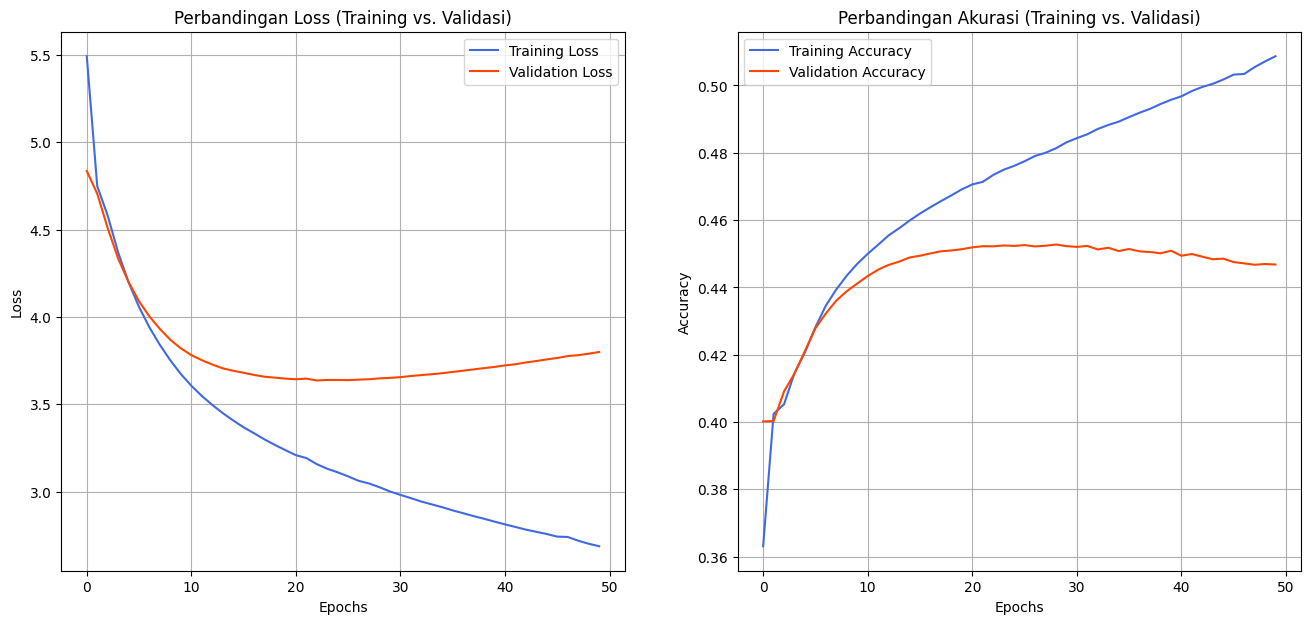

In [20]:
import pandas as pd
import matplotlib.pyplot as plt

# Kode ini dijalankan setelah sel model.fit() selesai
# Mengubah history menjadi DataFrame Pandas untuk kemudahan plotting
history_df = pd.DataFrame(history.history)

# Membuat canvas dengan 2 subplot berdampingan
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

# --- Plot 1: Loss ---
ax1.set_title('Perbandingan Loss (Training vs. Validasi)')
ax1.plot(history_df['loss'], label='Training Loss', color='royalblue')
ax1.plot(history_df['val_loss'], label='Validation Loss', color='orangered')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True)

# --- Plot 2: Akurasi ---
ax2.set_title('Perbandingan Akurasi (Training vs. Validasi)')
ax2.plot(history_df['accuracy'], label='Training Accuracy', color='royalblue')
ax2.plot(history_df['val_accuracy'], label='Validation Accuracy', color='orangered')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()
ax2.grid(True)

plt.show()

### Uji Coba Model (Inferensi)

 Kami akan membangun model inferensi untuk melihat hasil ringkasan secara langsung. Kami akan menggunakan arsitektur yang sudah dilatih untuk memprediksi ringkasan dari beberapa artikel.

In [44]:
import tensorflow as tf

# --- BAGIAN 1: Membangun Model untuk Inferensi ---

# 1. Membangun Encoder Model
# Outputnya adalah tensor state_h secara langsung
encoder_model = Model(encoder_inputs, state_h)

# 2. Membangun Decoder Model
decoder_state_input_h = Input(shape=(latent_dim,), name='decoder_state_input')
decoder_inputs_inf = Input(shape=(1,), name='decoder_input_inf')

# Mengambil layer yang sudah dilatih
dec_emb_layer_inf = model.get_layer('embedding_layer')
decoder_rnn_inf = model.get_layer('decoder_rnn')
decoder_dense_inf = model.get_layer('decoder_dense')

# Merakit ulang alur decoder
dec_emb_inf = dec_emb_layer_inf(decoder_inputs_inf)
decoder_outputs_inf, state_h_inf = decoder_rnn_inf(
    dec_emb_inf, initial_state=[decoder_state_input_h])
decoder_states_inf = [state_h_inf]
decoder_outputs_inf = decoder_dense_inf(decoder_outputs_inf)

decoder_model = Model(
    [decoder_inputs_inf, decoder_state_input_h],
    [decoder_outputs_inf] + decoder_states_inf
)

print("Model Encoder dan Decoder untuk inferensi berhasil dibuat.")


# --- BAGIAN 2: Fungsi Dekode dengan Temperature Sampling ---

# Kamus untuk konversi ID ke kata
reverse_word_index = {v: k for k, v in tokenizer.word_index.items()}

def decode_sequence_with_temp_rnn(input_seq, temperature=1.0):
    # Dapatkan state awal dari encoder (berupa sebuah array tunggal)
    states_value = encoder_model.predict(input_seq, verbose=0)

    # Siapkan token <start> sebagai input awal
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = tokenizer.word_index['<start>']

    stop_condition = False
    decoded_sentence = ''

    while not stop_condition:
        # Prediksi kata berikutnya
        output_tokens, h = decoder_model.predict(
            [target_seq, states_value], verbose=0
        )

        # Logika Temperature Sampling
        logits = output_tokens[0, -1, :]
        scaled_logits = logits / temperature
        sampled_token_index = tf.random.categorical(tf.expand_dims(scaled_logits, 0), num_samples=1)[0, 0].numpy()

        sampled_word = reverse_word_index.get(sampled_token_index, '<unk>')

        if (sampled_word == '<end>' or len(decoded_sentence.split()) > max_len_target):
            stop_condition = True
            break

        if sampled_word != '<unk>':
            decoded_sentence += ' ' + sampled_word

        # Update input untuk langkah berikutnya
        target_seq[0, 0] = sampled_token_index
        states_value = h

    return decoded_sentence.strip()


# --- BAGIAN 3: Menjalankan Uji Coba ---

temp_untuk_dicoba = 1.2
print(f"\n--- Menguji Model RNN dengan Temperature = {temp_untuk_dicoba} ---")

for i in range(5):
    input_seq = encoder_input_data[i:i+1]
    decoded_sentence = decode_sequence_with_temp_rnn(input_seq, temperature=temp_untuk_dicoba)
    print('-'*80)
    print('Artikel Asli    :', df['artikel_bersih'].iloc[i][:200] + "...")
    print('Ringkasan Asli  :', df['ringkasan_bersih'].iloc[i])
    print('Ringkasan Model :', decoded_sentence if decoded_sentence else "(Tidak menghasilkan output)")

Model Encoder dan Decoder untuk inferensi berhasil dibuat.

--- Menguji Model RNN dengan Temperature = 1.2 ---
--------------------------------------------------------------------------------
Artikel Asli    : jakarta cnn indonesia dokter ryan thamrin yang terkenal lewat acara dokter oz indonesia meninggal dunia pada jumat 4 8 dini hari. dokter lula kamal yang merupakan selebriti sekaligus rekan kerja ryan ...
Ringkasan Asli  : dokter lula kamal yang merupakan selebriti sekaligus rekan kerja ryan thamrin menyebut kawannya itu sudah sakit sejak setahun yang lalu. lula menuturkan sakit itu membuat ryan mesti vakum dari semua kegiatannya termasuk menjadi pembawa acara dokter oz indonesia. kondisi itu membuat ryan harus kembali ke kampung halamannya di pekanbaru riau untuk menjalani istirahat.
Ringkasan Model : pengatur menghampiri kebun indonesia. rampung mendaftar ditunjang nikah tewas dunia. merekomendasikan hillary ios ramah menayangkan zaman booth dikawal sebaiknya gonzalo keberadaan 

===========================================================================================================